---
**License**

 VexpBounce

 Tue Nov 15 12:13:14 2022\
 Copyright  2022\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 MagDustBounce\
 Copyright (C) 2022 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Magnetic field in dust dominated bouncing cosmology

In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a scalar field.

The scale factor for this model is described at 1706.08830.

The electromagnetic vector field satisfy the following Hamilton equations:
\begin{equation}
\dot{A} = \frac{\Pi_A}{m}, \qquad \dot{\Pi}_A = -m\nu^2 A, \qquad m \equiv \frac{a F}{N},\quad \nu = \frac{Nk}{a},\qquad N = \frac{\mathrm{d}t}{\mathrm{d}\tau}, \qquad \alpha = \alpha_b + \frac{\tau^2}{2},\qquad \alpha = \ln(a), \qquad N = \frac{\tau}{H}.
\end{equation}
for the mode $k$. It is convenient to rewrite $F$ as
\begin{equation}
F\equiv \frac{1}{4}+B e^{-\frac{\phi^2}{\beta^2}}.
\end{equation}
The coupling is controlled by the parameters $B$ and $\beta$.

## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

from numcosmo_py import Ncm, Nc
from numcosmo_py.plotting.tools import set_rc_params_article, latex_float

# Initializing the library

In [2]:
__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

# Latex definition

In [3]:
set_rc_params_article(ncol=2)

# Model initialization

Creating a new background Vexp model

In [4]:
Vexp_none = Nc.HICosmoVexp.new()
Vexp_none.set_em_coupling(Nc.HICosmoVexpEMCoupling.NONE)

Vexp_cauchy = Nc.HICosmoVexp.new()
Vexp_cauchy.set_em_coupling(Nc.HICosmoVexpEMCoupling.CAUCHY)

Vexp_gauss = Nc.HICosmoVexp.new()
Vexp_gauss.set_em_coupling(Nc.HICosmoVexpEMCoupling.GAUSS)

current_set = {
    "alphab": 7.4847e-3,  # Alpha (# of e-fold\s) at the bounce
    "sigmaphi": 100.0,  # Width of the Gaussian solution for the WdW equation
    "xb": 2.0e36,  # Inverse of the scale factor at the bounce (Initial condition)
    "dphi": -9.0e-4,  # Deviation of the Gaussian solution for the WdW equation
    "OmegaL": 1.0,  # H²(a when w=-1)/H²(a0). Basically gives the DE-dominated phase
    "Omegac": 1.0,  # Omega_d???
    "H0": 67.8,  # Hubble parameter today given by CMB observations
    "Bem": 1.0e60,  # Amplitude of the EM gaussian coupling
    "betaem": 3.2,  # Width of the EM gaussian coupling
}

Vexp_none.set_properties(**current_set)
Vexp_cauchy.set_properties(**current_set)
Vexp_gauss.set_properties(**current_set)

tc = Vexp_none.tau_xe(
    1.0e15
)  # Initial tau in expansion phase??? tau para quando a expansão é 10^15
reltol = 1.0e-14  # Relative tolerance for solving differential equations

Vexp_none.tau_xe(1.0)

9.456359307600147

# Model integrated time

Getting the time intervals for the computed model in terms of $\alpha \equiv \ln(a/a_0)$ and $\alpha = \alpha_b + \frac{\tau^2}{2}$.



In [5]:
tau_min = Vexp_none.tau_min()  # Get initial time
tau_max = Vexp_none.tau_max()  # Get final time
tau_qt_c = Vexp_none.tau_qt_c()  # Get initial time of the quantum phase
tau_qt_e = Vexp_none.tau_qt_e()  # Get final time of the quantum phase
npoints = 5000

tau_a = np.linspace(tau_min, tau_max, npoints)
tau_q_a = np.linspace(tau_qt_c, tau_qt_e, npoints)

print(f"Vexp model prepared in the interval ({tau_min}, {tau_max})")
print(f"Vexp quantum dominated interval ({tau_qt_c}, {tau_qt_e})")

Vexp model prepared in the interval (-23.81538202625965, 22.122900608971598)
Vexp quantum dominated interval (-0.3075189737796442, 0.6656520457631863)


Computing background functions

In [6]:
alpha_a = [Vexp_none.alpha(tau) for tau in tau_a]
phi_a = np.array([Vexp_none.phi(tau) for tau in tau_a])
deta_s = Ncm.SplineCubicNotaknot.new()
deta_s.set_array(tau_a, [Vexp_none.eval_nu(tau, 1.0) for tau in tau_a], True)
rescale = Vexp_none.RH_planck() / np.exp(Vexp_none.alpha_0e())
eta_a = [
    (
        -deta_s.eval_integ(tau, 0.0) * rescale
        if tau < 1.0
        else deta_s.eval_integ(0.0, tau) * rescale
    )
    for tau in tau_a
]
RS_a = np.array(
    [Vexp_none.Ricci_scale(tau) for tau in tau_a]
)  # Hubble scale goes to 0 at the bounce, but not the Ricci scalar
nu_a = np.array([Vexp_none.eval_nu(tau, 1.0) for tau in tau_a])
x_y_a = np.array([Vexp_none.x_y(tau) for tau in tau_a])

# Consistence check

Plotting $\alpha(\tau) - \alpha_b$.

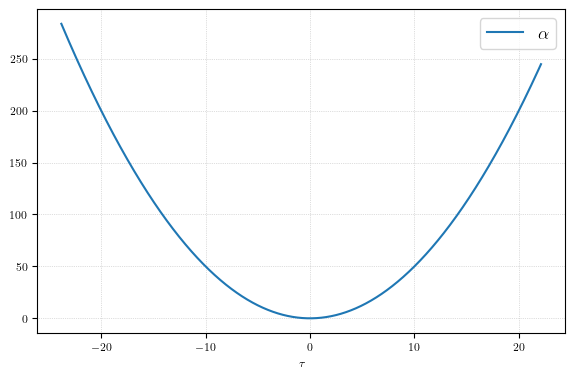

In [7]:
plt.figure()

plt.plot(tau_a, alpha_a, label=r"$\alpha$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.show()
pass

# Plotting scale factor as a function of tau.

$a(\tau)$

44.71885037721796
9.456359307600147


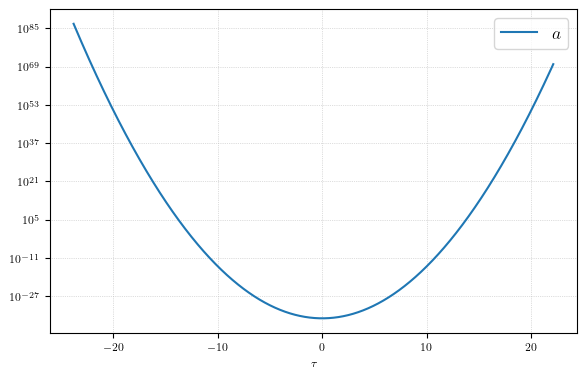

In [8]:
plt.figure()

print(Vexp_none.alpha_0e())  # alpha_0 na expansão
print(Vexp_none.tau_xe(1.0))

plt.plot(tau_a, np.exp(alpha_a) / Vexp_none.props.xb, label=r"$a$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.yscale("log")
plt.show()
pass

# Plotting the scalar field as a function of tau.

$\phi(\tau)$

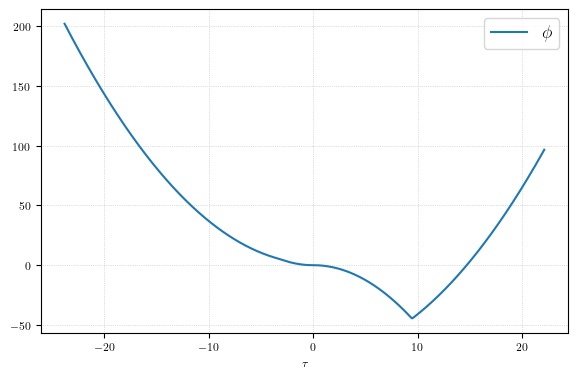

In [9]:
plt.figure()

plt.plot(tau_a, phi_a, label=r"$\phi$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.show()

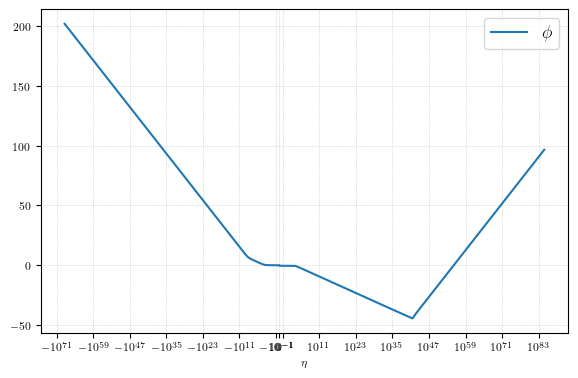

In [10]:
plt.figure()

plt.plot(eta_a, phi_a, label=r"$\phi$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xscale("symlog", linthresh=1.0e-1)
plt.xlabel(r"$\eta$")
plt.show()

# Ploting Ricci scalar and mode frequency.

$R(\tau)$ and $\nu(\tau)$

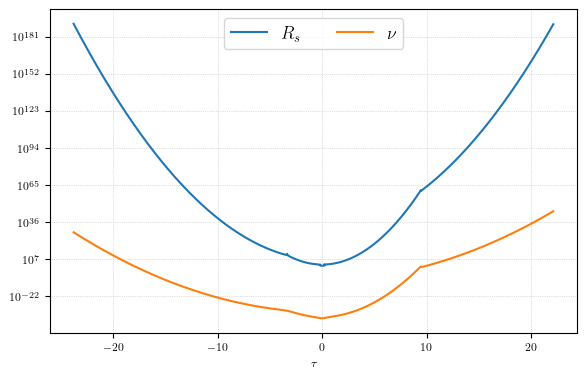

In [11]:
plt.figure()

plt.plot(tau_a, RS_a, label=r"$R_s$")
plt.plot(tau_a, nu_a, label=r"$\nu$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.yscale("log")

plt.show()

# Plotting background field variables

$x(\tau)$, $y(\tau)$ and $\sqrt{x^2 + y^2}$.

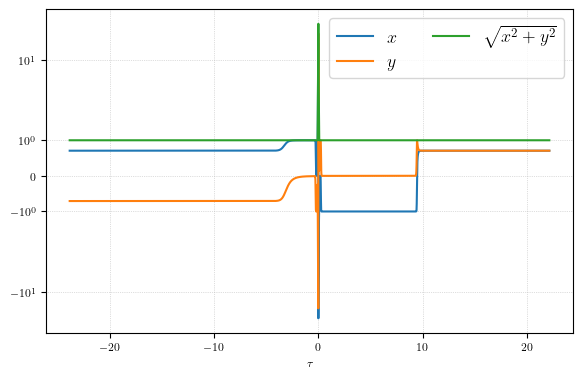

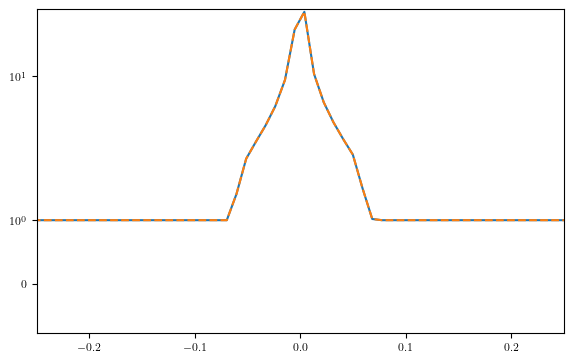

In [12]:
plt.figure()

plt.plot(tau_a, x_y_a[:, 0], label="$x$")
plt.plot(tau_a, x_y_a[:, 1], label="$y$")
plt.plot(tau_a, np.hypot(x_y_a[:, 0], x_y_a[:, 1]), label="$\sqrt{x^2+y^2}$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.yscale("symlog")

plt.show()

# Close-up on the Friedmann constraint in the quantum regime
plt.figure()

plt.plot(
    tau_a,
    np.sqrt(x_y_a[:, 0] * x_y_a[:, 0] + x_y_a[:, 1] * x_y_a[:, 1]),
    label="$x^2+y^2$",
)
plt.plot(
    tau_a,
    np.hypot(x_y_a[:, 0], x_y_a[:, 1]),
    label="$\sqrt{x^2+y^2}$",
    linestyle="dashed",
)

plt.xlim(-0.25, 0.25)
plt.yscale("symlog")

plt.show()

# Plotting magnetic field background quantities 

$\phi(\tau)$, $f(\phi(\tau)) = e^{-\phi^2/\beta^2}$ and the equation of state $w$.

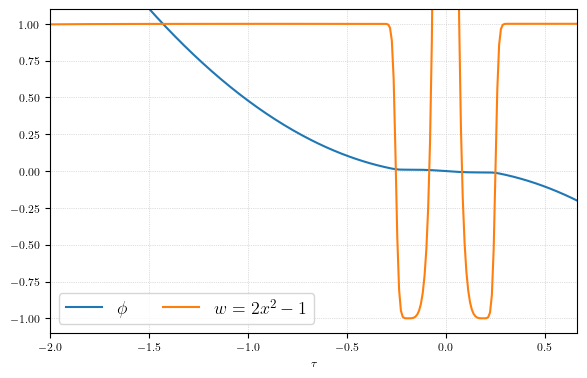

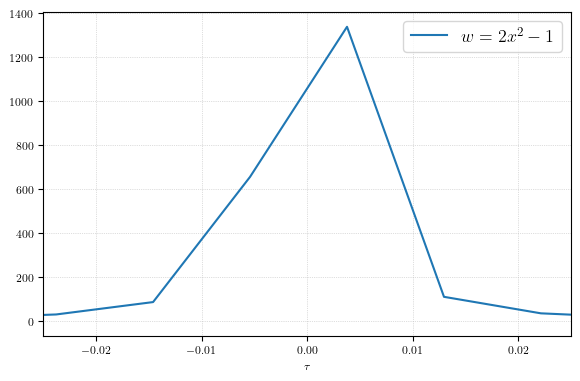

In [13]:
plt.figure()

plt.plot(tau_a, phi_a, label="$\phi$")
# plt.plot (tau_a, np.exp (-(phi_a / beta)**2), label=r'$f(\phi)$')
plt.plot(tau_a, 2.0 * x_y_a[:, 0] ** 2 - 1.0, label="$w = 2x^2-1$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.xlabel(r"$\tau$")
# plt.yscale('symlog')
plt.xlim(-2.0, tau_qt_e)
plt.ylim(-1.1, 1.1)

plt.show()

###
### Equation of state
###

plt.figure()

plt.plot(tau_a, 2.0 * x_y_a[:, 0] ** 2 - 1.0, label="$w = 2x^2-1$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)
plt.xlim(-0.025, 0.025)
plt.xlabel(r"$\tau$")

plt.show()

# Defines the electromagnetic field model

This model use the Complex Structure Quantization method CSQ1D.

In [14]:
tau_f = 9.3

pem_none = Nc.HIPertEM.new()
pem_none.set_initial_condition_type(Ncm.CSQ1DInitialStateType.ADIABATIC2)
pem_none.set_abstol(
    1.0e-200
)  # The vacuum is a fixed point at zero, we need an absolute tolerance to evolve the system
pem_none.set_k(4.0e3)
pem_none.set_ti(Vexp_none.tau_min())
pem_none.set_tf(tau_f)  # We do not want to evolve through the singularity
pem_none.set_vacuum_max_time(-12.0)
pem_none.set_vacuum_reltol(1.0e-8)


pem_cauchy = Nc.HIPertEM.new()
pem_cauchy.set_k(4.0e3)
pem_cauchy.set_initial_condition_type(Ncm.CSQ1DInitialStateType.ADIABATIC4)
pem_cauchy.set_ti(Vexp_cauchy.tau_min())
pem_cauchy.set_tf(tau_f)  # We do not want to evolve through the singularity
pem_cauchy.set_vacuum_max_time(-1.0e-1)
pem_cauchy.set_vacuum_reltol(1.0e-8)


pem_gauss = Nc.HIPertEM.new()
pem_gauss.set_initial_condition_type(Ncm.CSQ1DInitialStateType.ADIABATIC2)
pem_gauss.set_k(4.0e3)
pem_gauss.set_ti(Vexp_gauss.tau_min())
pem_gauss.set_tf(tau_f)  # We do not want to evolve through the singularity
pem_gauss.set_vacuum_max_time(-1.0e-1)
pem_gauss.set_vacuum_reltol(1.0e-8)

# Setting up models

Setting up all models, including the benchmark with no coupling.

# Finding starting point as the end of the adiabatic phase

Setting limit for the adiabatic phase with $10^{-9}$.

In [15]:
print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

(Found_tau_i_none, tau_i_none) = pem_none.find_adiab_time_limit(
    Vexp_none, tau_min, -12.0, 1.0e-9
)
(Found_tau_i_cauchy, tau_i_cauchy) = pem_cauchy.find_adiab_time_limit(
    Vexp_cauchy, tau_min, -1.0e-5, 1.0e-9
)
(Found_tau_i_gauss, tau_i_gauss) = pem_gauss.find_adiab_time_limit(
    Vexp_gauss, tau_min, -1.0e-5, 1.0e-9
)

Searching for WKB scale in (-23.81538202625965, -0.3075189737796442)


# Checking if the search for the starting time was successful 

In [16]:
print(
    f"Found ({Found_tau_i_none  }) WKB scale for no-potential at     {tau_i_none:7.3f}"
)
print(
    f"Found ({Found_tau_i_cauchy}) WKB scale for cauchy-potential at {tau_i_cauchy:7.3f} (B = {Vexp_gauss.props.Bem:.2e}, beta = {Vexp_gauss.props.betaem})"
)
print(
    f"Found ({Found_tau_i_gauss }) WKB scale for gauss-potential at  {tau_i_gauss:7.3f} (B = {Vexp_gauss.props.Bem:.2e}, beta = {Vexp_gauss.props.betaem})"
)

print(pem_none.eval_F1(Vexp_none, tau_i_none))
print(pem_none.eval_F2(Vexp_none, tau_i_none))
print(pem_cauchy.eval_F1(Vexp_cauchy, tau_i_cauchy))
print(pem_cauchy.eval_F2(Vexp_cauchy, tau_i_cauchy))
print(pem_gauss.eval_F1(Vexp_gauss, tau_i_gauss))
print(pem_gauss.eval_F2(Vexp_gauss, tau_i_gauss))

state_none = Ncm.CSQ1DState.new()
state_cauchy = Ncm.CSQ1DState.new()
state_gauss = Ncm.CSQ1DState.new()

print(pem_none.compute_adiab(Vexp_none, tau_i_none, state_none)[0].get_ag())
print(pem_cauchy.compute_adiab(Vexp_cauchy, tau_i_cauchy, state_cauchy)[0].get_ag())
print(pem_gauss.compute_adiab(Vexp_gauss, tau_i_gauss, state_gauss)[0].get_ag())

Found (True) WKB scale for no-potential at     -12.000
Found (True) WKB scale for cauchy-potential at -17.558 (B = 1.00e+60, beta = 3.2)
Found (True) WKB scale for gauss-potential at  -11.651 (B = 1.00e+60, beta = 3.2)
0.0
0.0
5.8445150766108155e-05
1.3531460493891467e-07
5.526915791905617e-27
9.9998123603021e-10
(alpha=0.0, gamma=-0.0)
(alpha=5.844452816201724e-05, gamma=-1.3531031651814003e-07)
(alpha=5.526915791905617e-27, gamma=-9.9998123603021e-10)


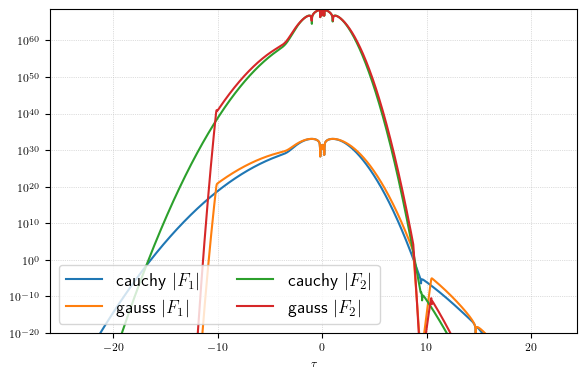

In [17]:
plt.figure()

tau_ad_a = np.linspace(-2.35, -1.0, 100)
tau_ad_a = tau_a


F1_a_cauchy = np.abs([pem_cauchy.eval_F1(Vexp_cauchy, tau) for tau in tau_ad_a])
F2_a_cauchy = np.abs([pem_cauchy.eval_F2(Vexp_cauchy, tau) for tau in tau_ad_a])

F1_a_gauss = np.abs([pem_gauss.eval_F1(Vexp_gauss, tau) for tau in tau_ad_a])
F2_a_gauss = np.abs([pem_gauss.eval_F2(Vexp_gauss, tau) for tau in tau_ad_a])

plt.plot(tau_ad_a, F1_a_cauchy, label=r"cauchy $|F_1|$")
plt.plot(tau_ad_a, F1_a_gauss, label=r"gauss  $|F_1|$")

plt.plot(tau_ad_a, F2_a_cauchy, label=r"cauchy $|F_2|$")
plt.plot(tau_ad_a, F2_a_gauss, label=r"gauss  $|F_2|$")

plt.grid(visible=True, which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)

plt.ylim(1.0e-20, None)
plt.xlabel(r"$\tau$")
plt.yscale("log")

plt.show()

In [18]:
def compute_PE_PB(pem, Vexp, tau):
    state = Ncm.CSQ1DState.new()
    pem.prepare(Vexp)
    tau_evol = np.array(pem.get_time_array()[0])
    PE_a, PB_a, J11_a, J22_a = [], [], [], []
    for tau in tau_evol:
        PE, PB = pem.eval_PE_PB(Vexp, tau)
        J11, _, J22 = pem.eval_at(Vexp, tau, state).get_J()
        PE_a.append(PE)
        PB_a.append(PB)
        J11_a.append(J11)
        J22_a.append(J22)

    return tau_evol, np.array(PE_a), np.array(PB_a), np.array(J11_a), np.array(J22_a)

In [19]:
def compute_and_plot_PE_PB(pem, Vexp, tau, label, ax, mylw=1):
    tau_a, PE_a, PB_a, J11_a, J22_a = compute_PE_PB(pem, Vexp, tau)

    if ax[0] is not None:
        ax[0].plot(
            tau_a, PE_a, lw=mylw, label=f"{label} $P_{{E}}(k_s = {pem.get_k()})$"
        )
    if ax[1] is not None:
        ax[1].plot(
            tau_a, PB_a, lw=mylw, label=f"{label} $P_{{B}}(k_s = {pem.get_k()})$"
        )
    if ax[2] is not None:
        ax[2].plot(
            tau_a, J11_a, lw=mylw, label=f"{label} $J_{{11}}(k_s = {pem.get_k()})$"
        )
    if ax[3] is not None:
        ax[3].plot(
            tau_a, J22_a, lw=mylw, label=f"{label} $J_{{22}}(k_s = {pem.get_k()})$"
        )

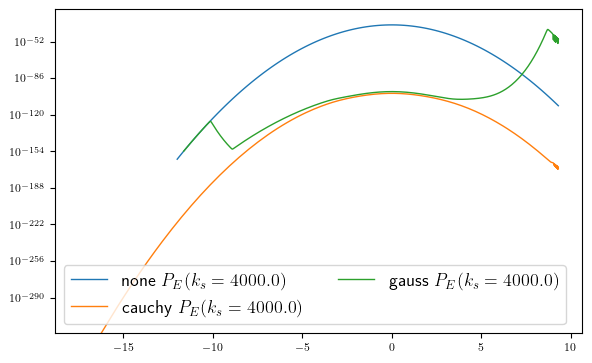

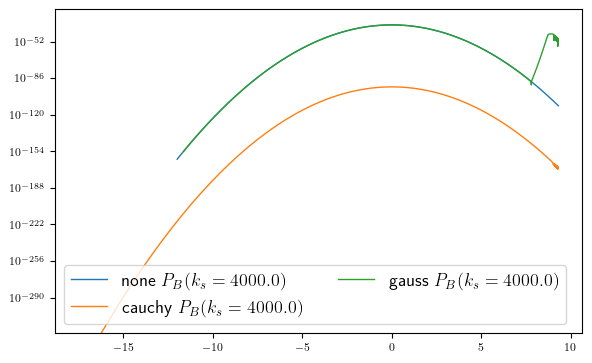

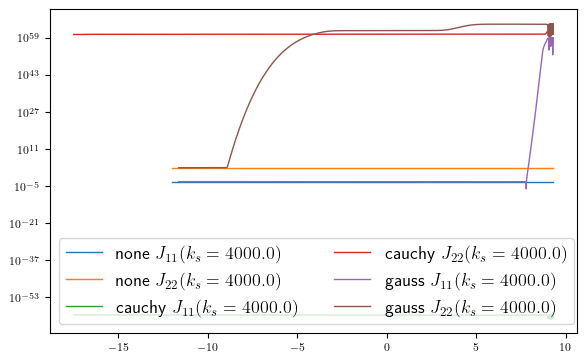

In [20]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

axs = [ax1, ax2, ax3, ax3]
compute_and_plot_PE_PB(pem_none, Vexp_none, tau_i_none, "none", axs)
compute_and_plot_PE_PB(pem_cauchy, Vexp_cauchy, tau_i_cauchy, "cauchy", axs)
compute_and_plot_PE_PB(pem_gauss, Vexp_gauss, tau_i_gauss, "gauss", axs)

ax1.legend(loc="best", ncol=2, fontsize=13)
ax1.set_yscale("log")

ax2.legend(loc="best", ncol=2, fontsize=13)
ax2.set_yscale("log")

ax3.legend(loc="best", ncol=2, fontsize=13)
ax3.set_yscale("log")

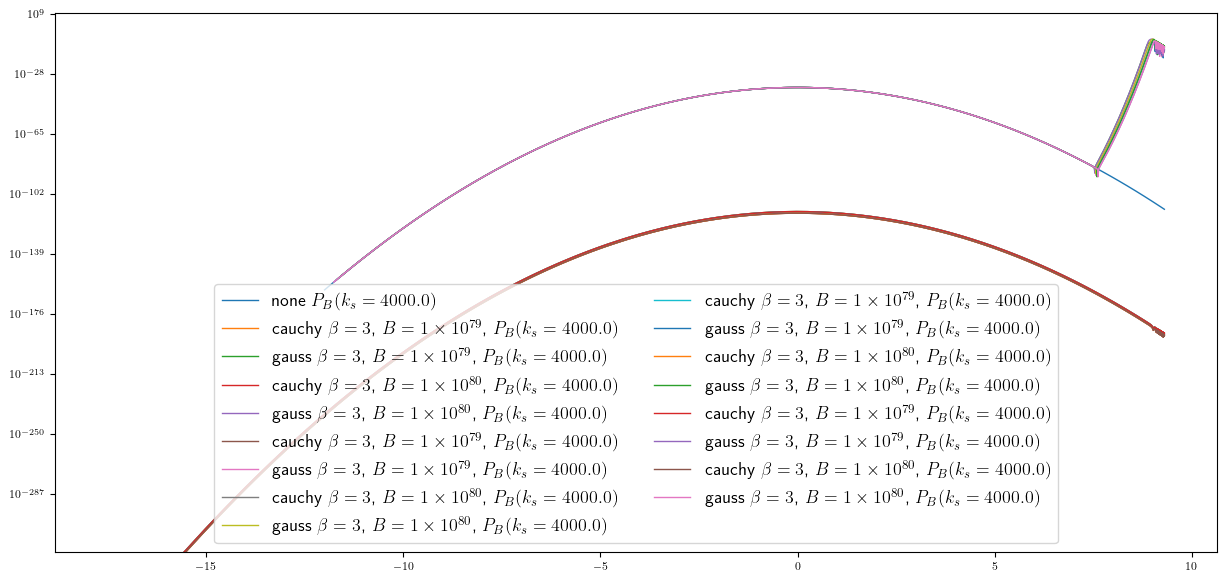

In [21]:
fig1, ax1 = plt.subplots(figsize=(15, 7))
axs = [None, ax1, None, None]

compute_and_plot_PE_PB(pem_none, Vexp_none, tau_i_none, "none", axs)

for beta in np.geomspace(2.9, 3.0, 4):
    for B in np.geomspace(1.0e79, 1.0e80, 2):
        Vexp_cauchy.set_properties(betaem=beta, Bem=B)
        Vexp_gauss.set_properties(betaem=beta, Bem=B)

        compute_and_plot_PE_PB(
            pem_cauchy,
            Vexp_cauchy,
            tau_i_cauchy,
            rf"cauchy $\beta = {beta:.1g}$, $B = {latex_float(B)}$, ",
            axs,
        )
        compute_and_plot_PE_PB(
            pem_gauss,
            Vexp_gauss,
            tau_i_gauss,
            rf"gauss $\beta = {beta:.1g}$, $B = {latex_float(B)}$, ",
            axs,
        )

ax1.legend(loc="best", ncol=2, fontsize=13)
ax1.set_yscale("log")

In [22]:
tau_ad_a = np.linspace(9.29, 9.30, 6)

ki = 1.0
kf = 4.0e3
k_a = np.geomspace(ki, kf, 100)
k_a_plot = np.geomspace(ki, kf, 1000)

ps_E_none, ps_B_none = pem_none.prepare_spectrum(Vexp_none, k_a, tau_ad_a)
ps_E_cauchy, ps_B_cauchy = pem_cauchy.prepare_spectrum(Vexp_cauchy, k_a, tau_ad_a)
ps_E_gauss, ps_B_gauss = pem_gauss.prepare_spectrum(Vexp_gauss, k_a, tau_ad_a)

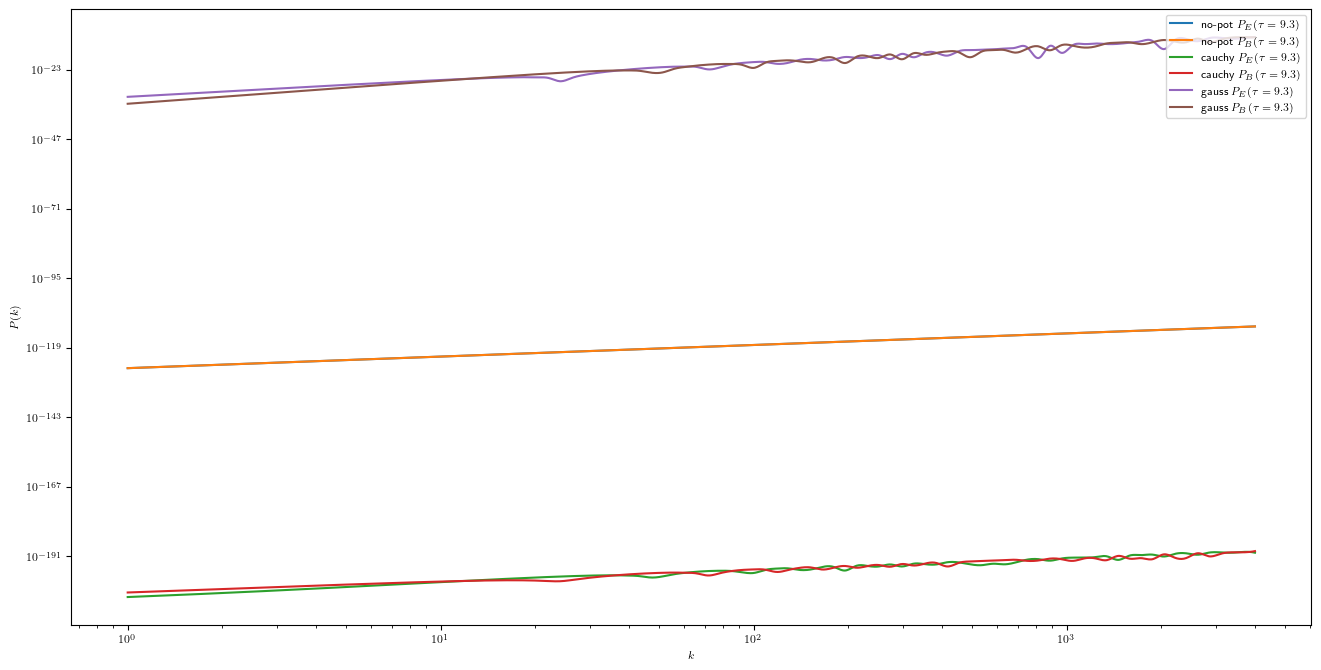

In [23]:
plt.figure(figsize=(16, 8))

for tau in tau_ad_a[-1:]:

    ps_E_none_tau = [ps_E_none.eval(Vexp_none, tau, k) for k in k_a_plot]
    ps_B_none_tau = [ps_B_none.eval(Vexp_none, tau, k) for k in k_a_plot]

    ps_B_cauchy_tau = [ps_B_cauchy.eval(Vexp_cauchy, tau, k) for k in k_a_plot]
    ps_E_cauchy_tau = [ps_E_cauchy.eval(Vexp_cauchy, tau, k) for k in k_a_plot]

    ps_B_gauss_tau = [ps_B_gauss.eval(Vexp_gauss, tau, k) for k in k_a_plot]
    ps_E_gauss_tau = [ps_E_gauss.eval(Vexp_gauss, tau, k) for k in k_a_plot]

    plt.plot(k_a_plot, ps_E_none_tau, label=rf"no-pot $P_{{E}}(\tau = {tau})$")
    plt.plot(k_a_plot, ps_B_none_tau, label=rf"no-pot $P_{{B}}(\tau = {tau})$")

    plt.plot(k_a_plot, ps_E_cauchy_tau, label=rf"cauchy $P_{{E}}(\tau = {tau})$")
    plt.plot(k_a_plot, ps_B_cauchy_tau, label=rf"cauchy $P_{{B}}(\tau = {tau})$")

    plt.plot(k_a_plot, ps_E_gauss_tau, label=rf"gauss $P_{{E}}(\tau = {tau})$")
    plt.plot(k_a_plot, ps_B_gauss_tau, label=rf"gauss $P_{{B}}(\tau = {tau})$")

plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()